In [30]:
# from transformers.data.processors.squad import SquadResult, SquadV1Processor

# processor = SquadV1Processor()
# examples = processor.get_dev_examples(args.data_dir, filename=args.predict_file)

In [2]:
import torch
import json
import collections
from squad import SquadResult, SquadV1Processor, SquadV2Processor
from squad_metrics import (
    compute_predictions_log_probs,
    compute_predictions_logits,
    squad_evaluate,
)

cached_features_file='tydiqa/cached_dev_tydiqa-gold_384_'
pred_file='tydiqa/predictions_.json'
features_and_dataset = torch.load(cached_features_file)

examples = features_and_dataset["examples"]
predictions=json.load(open(pred_file))

In [3]:
langs = ['swahili','bengali','arabic','korean','english','indonesian','japanese','russian',
        'telugu','finnish','thai']

for lan in langs:
    name = lan+'--'
    new_examples=[]
    new_preds=collections.OrderedDict()
    for exam in examples:
        if exam.qas_id.startswith(name)==True:
            new_examples.append(exam)
            new_preds[exam.qas_id]=predictions[exam.qas_id]
    if len(new_examples)!=0:
        results = squad_evaluate(new_examples, new_preds)
        print(name)
        print(results)

for lan in langs[:-1]:
    name = lan+'-english--'
    new_examples=[]
    new_preds=collections.OrderedDict()
    for exam in examples:
        if exam.qas_id.startswith(name)==True:
            new_examples.append(exam)
            new_preds[exam.qas_id]=predictions[exam.qas_id]
    if len(new_examples)!=0:
        results = squad_evaluate(new_examples, new_preds)
        print(name)
        print(results)

for lan in langs[:-1]:
    name = 'english-'+lan+'--'
    new_examples=[]
    new_preds=collections.OrderedDict()
    for exam in examples:
        if exam.qas_id.startswith(name)==True:
            new_examples.append(exam)
            new_preds[exam.qas_id]=predictions[exam.qas_id]
    if len(new_examples)!=0:
        results = squad_evaluate(new_examples, new_preds)
        print(name)
        print(results)

swahili--
OrderedDict([('exact', 71.62162162162163), ('f1', 80.8446776093835), ('total', 222), ('HasAns_exact', 71.62162162162163), ('HasAns_f1', 80.8446776093835), ('HasAns_total', 222), ('best_exact', 71.62162162162163), ('best_exact_thresh', 0.0), ('best_f1', 80.8446776093835), ('best_f1_thresh', 0.0)])
bengali--
OrderedDict([('exact', 64.70588235294117), ('f1', 79.89644342585517), ('total', 51), ('HasAns_exact', 64.70588235294117), ('HasAns_f1', 79.89644342585517), ('HasAns_total', 51), ('best_exact', 64.70588235294117), ('best_exact_thresh', 0.0), ('best_f1', 79.89644342585517), ('best_f1_thresh', 0.0)])
arabic--
OrderedDict([('exact', 65.17857142857143), ('f1', 81.28870777615433), ('total', 448), ('HasAns_exact', 65.17857142857143), ('HasAns_f1', 81.28870777615433), ('HasAns_total', 448), ('best_exact', 65.17857142857143), ('best_exact_thresh', 0.0), ('best_f1', 81.28870777615433), ('best_f1_thresh', 0.0)])
korean--
OrderedDict([('exact', 14.084507042253522), ('f1', 34.7957281077

In [4]:
import os 
import json
import pickle

def get_qdata(filename):

    with open(filename,'r') as f:
        data=json.loads(f.read())
    mlqa_q={}
    i=0
    for dat in data['data']:
    #     if i>2:
    #         break
    #     print(dat)
        for par in dat['paragraphs']:
            for qos in par['qas']:
                mlqa_q[qos['id']] = qos['question'].strip()
                i+=1
    print(i, len(mlqa_q))
    if i!=len(mlqa_q):
        mlqa_q={}
        i=0
        for dat in data['data']:
        #     if i>2:
        #         break
        #     print(dat)
            for par in dat['paragraphs']:
                for qos in par['qas']:
                    if qos['id'] not in mlqa_q:
                        mlqa_q[qos['id']]=[qos['question'].strip()]
                    else:
                        mlqa_q[qos['id']].append(qos['question'].strip())
                    i+=1
        print(i, len(mlqa_q))        
    return mlqa_q

In [439]:
from wikidata.client import Client
import json
import os

json_name = 'tydiqa_data/all_d.json'
with open(json_name) as inp:
    jsonstr = inp.read()
ent_ids = json.loads(jsonstr)

json_name = 'country_dict.json'
with open(json_name) as inp:
    jsonstr = inp.read()
countries = json.loads(jsonstr)

json_name = 'id2geo.json'
with open(json_name) as inp:
    jsonstr = inp.read()
id2geo = json.loads(jsonstr)

json_name = 'place2country.json'
with open(json_name) as inp:
    jsonstr = inp.read()
place2coun = json.loads(jsonstr)

with open('data/country_maps.pickle','rb') as f:
    country_maps=pickle.load(f)

def check_country(x):
    x=x.lower()
    if x=='scotland':
        print(x,country_maps[x])
    if x in country_maps:
        coun = country_maps[x].lower()
    else:
        coun=x
    return coun

def get_orig_id_ent(id_ques,all_q_id, all_ent):
    client = Client()
    orig_id_ent={}
    tags=['country','citizen','born','died']
    for ids,q in id_ques.items():
        lang=ids.split('-')[0]
        if q in all_q_id[lang]:
            ent=all_ent[lang][int(all_q_id[lang][q])]
            orig_id_ent[ids]=[]
            if ent in ent_ids:
    #             print(q,ent_ids[ent],ent)
                for x,j in ent_ids[ent].items():
                    if x in tags:
                        if j in countries: 
                            orig_id_ent[ids].append(check_country(countries[j]))
                        elif j in id2geo:
                            orig_id_ent[ids].append(check_country(id2geo[j]['country']))
                        elif j in place2coun:
                            orig_id_ent[ids].append(check_country(place2coun[j]['country']))
                        else:
                            place = client.get(j, load=True)
                            for key2 in place.keys():
                                if key2.id == 'P17':
                                    try:
                                        countryid = place[key2].id
                                        orig_id_ent[ids].append(check_country(countries[countryid]))
#                                         print(x,j,countries[countryid])
                                    except:
                                        print(key2,  place)
                orig_id_ent[ids]=set(orig_id_ent[ids])
    return orig_id_ent

def get_coun2ids(orig_id_ent):
    coun2ids={}
    for ids, coun in orig_id_ent.items():
        if len(coun)!=0:
            for x in coun:
                if x not in coun2ids:
                    coun2ids[x]=[ids]
                else:
                    coun2ids[x].append(ids)
    return coun2ids

#### train file

In [513]:
import pickle

datapath='../data/sentences/tydiqa'


id_ques=get_qdata(os.path.join('tydiqa','tydiqa-goldp-v1.1-train.json'))
ques_id = {j:i for i,j in id_ques.items()}

all_q={}
all_q_id={}
all_q_list=[]
for f in os.listdir(datapath):
    if 'train' in f and 'train-bn' not in f:
        with open(os.path.join(datapath,f),'rb') as f1:
            sents=pickle.load(f1)
            sents=[x.replace('[START] ','').replace(' [END]','') for x in sents]
            name=f.split('.')[0].replace('tydiqa-train-','')
            all_q[name]=sents
            all_q_id[name]={x:i for i,x in enumerate(sents)}
            

import pickle

datapath='../data/entities/tydiqa'

all_ent={}
all_ent_id={}

for f in os.listdir(datapath):
    if 'train' in f and 'train-bn' not in f:
        with open(os.path.join(datapath,f),'rb') as f1:
            sents=pickle.load(f1)
            name=f.split('.')[0].replace('tydiqa-train-','')
            all_ent[name]=[x[0]['id'] if len(x)>=1 else '0' for x in sents]

49881 49881


In [514]:
orig_train = get_orig_id_ent(id_ques,all_q_id, all_ent)
coun2ids_train = get_coun2ids(orig_train)
langs = ['swahili','bengali','arabic','korean','english','indonesian','japanese','russian',
        'telugu','finnish','thai']
count_train={}
for lang in langs:
    count_train[lang]={}
    for countr,ids in coun2ids_train.items():
        for id_one in ids:
            if lang in id_one:
                if countr not in count_train[lang]:
                    count_train[lang][countr]=1
                else:
                    count_train[lang][countr]+=1

<wikidata.entity.Entity P17> <wikidata.entity.Entity Q97 'Atlantic Ocean'>
scotland united kingdom
<wikidata.entity.Entity P17> <wikidata.entity.Entity Q97 'Atlantic Ocean'>
scotland united kingdom
scotland united kingdom
<wikidata.entity.Entity P17> <wikidata.entity.Entity Q97 'Atlantic Ocean'>
<wikidata.entity.Entity P17> <wikidata.entity.Entity Q97 'Atlantic Ocean'>
<wikidata.entity.Entity P17> <wikidata.entity.Entity Q19014 'Garden of Eden'>


#### dev file

In [515]:
import pickle

datapath='../data/sentences/tydiqa'

types='dev'
id_ques=get_qdata(os.path.join('tydiqa','tydiqa-goldp-v1.1-{}.json'.format(types)))
ques_id = {j:i for i,j in id_ques.items()}

all_q={}
all_q_id={}
all_q_list=[]
for f in os.listdir(datapath):
    if types in f and 'train-bn' not in f:
        with open(os.path.join(datapath,f),'rb') as f1:
            sents=pickle.load(f1)
            sents=[x.replace('[START] ','').replace(' [END]','') for x in sents]
            name=f.split('.')[0].replace('tydiqa-{}-'.format(types),'')
            all_q[name]=sents
            all_q_id[name]={x:i for i,x in enumerate(sents)}
            

import pickle

datapath='../data/entities/tydiqa'

all_ent={}
all_ent_id={}
all_sents={}
for f in os.listdir(datapath):
    if types in f and 'train-bn' not in f:
        with open(os.path.join(datapath,f),'rb') as f1:
            sents=pickle.load(f1)
            name=f.split('.')[0].replace('tydiqa-{}-'.format(types),'')
#             all_sents[name]=sents
            all_ent[name]=[x[0]['id'] if len(x)>=1 else '0' for x in sents]

5077 5077


In [516]:
orig_dev = get_orig_id_ent(id_ques,all_q_id, all_ent)
coun2ids_dev = get_coun2ids(orig_dev)
langs = ['swahili','bengali','arabic','korean','english','indonesian','japanese','russian',
        'telugu','finnish','thai']
count_dev={}
for lang in langs:
    count_dev[lang]={}
    for countr,ids in coun2ids_dev.items():
        for id_one in ids:
            if lang in id_one:
                if countr not in count_dev[lang]:
                    count_dev[lang][countr]=1
                else:
                    count_dev[lang][countr]+=1

scotland united kingdom
scotland united kingdom


In [517]:
langs = ['swahili','bengali','arabic','korean','english','indonesian','japanese','russian',
        'telugu','finnish','thai']

dev_result={}
for lan in langs:
    name = lan+'-'
    dev_result[lan]={}
    for cname,ids in coun2ids_dev.items():
        new_examples=[]
        new_preds=collections.OrderedDict()
        for exam in examples:
            if exam.qas_id.startswith(name)==True and exam.qas_id in ids:
                new_examples.append(exam)
                new_preds[exam.qas_id]=predictions[exam.qas_id]
            
            
        if len(new_examples)!=0:
            results = squad_evaluate(new_examples, new_preds)
#             print(name,cname,len(new_examples))
#             print(results['f1'])
            dev_result[lan][cname]=results['f1']

In [518]:
# count_train,count_dev,dev_result

#### analysis

In [519]:
def get_within_between(orig_split, count_split,result,split):
    lang_trainc={}
    langs = ['swahili','bengali','arabic','korean','english','indonesian','japanese','russian',
            'telugu','finnish','thai']
    lang_trainc['total']=0
    for lang in langs:
        for x in orig_split.keys():
            if lang in x:
                if lang not in lang_trainc:
                    lang_trainc[lang]=1
                else:
                    lang_trainc[lang]+=1
        if lang in lang_trainc:
            lang_trainc['total']+=lang_trainc[lang]

    gby_coun={}
    for lang,couns in count_split.items():
        for coun,count in couns.items():
            if coun not in gby_coun:
                gby_coun[coun]={}
            gby_coun[coun][lang]={
                'count':count,
                'within_lang':round(100*(count/lang_trainc[lang]),2),
                'between_lang':round(100*(count/lang_trainc['total']),2)
            }
            if split=='dev':
                gby_coun[coun][lang]['f1']=result[lang][coun]
    return gby_coun

In [520]:
gby_countrain=get_within_between(orig_train, count_train,dev_result,'train')
gby_coundev=get_within_between(orig_dev, count_dev,dev_result,'dev')

In [521]:
import pandas as pd
df_dev = pd.DataFrame.from_dict(gby_coundev).T
df_dev

,swahili,arabic,korean,english,indonesian,russian,finnish,bengali,telugu
italy,"{'count': 6, 'within_lang': 1.2, 'between_lang...","{'count': 21, 'within_lang': 2.28, 'between_la...","{'count': 5, 'within_lang': 1.81, 'between_lan...","{'count': 4, 'within_lang': 0.91, 'between_lan...","{'count': 10, 'within_lang': 1.77, 'between_la...","{'count': 13, 'within_lang': 1.6, 'between_lan...","{'count': 18, 'within_lang': 2.3, 'between_lan...",NaN,NaN
germany,"{'count': 15, 'within_lang': 3.01, 'between_la...","{'count': 13, 'within_lang': 1.41, 'between_la...","{'count': 13, 'within_lang': 4.71, 'between_la...","{'count': 7, 'within_lang': 1.59, 'between_lan...","{'count': 16, 'within_lang': 2.83, 'between_la...","{'count': 64, 'within_lang': 7.88, 'between_la...","{'count': 82, 'within_lang': 10.49, 'between_l...","{'count': 2, 'within_lang': 1.77, 'between_lan...","{'count': 1, 'within_lang': 0.15, 'between_lan..."
united states,"{'count': 26, 'within_lang': 5.21, 'between_la...","{'count': 31, 'within_lang': 3.37, 'between_la...","{'count': 30, 'within_lang': 10.87, 'between_l...","{'count': 47, 'within_lang': 10.68, 'between_l...","{'count': 26, 'within_lang': 4.6, 'between_lan...","{'count': 36, 'within_lang': 4.43, 'between_la...","{'count': 79, 'within_lang': 10.1, 'between_la...",NaN,"{'count': 13, 'within_lang': 1.94, 'between_la..."
egypt,"{'count': 4, 'within_lang': 0.8, 'between_lang...","{'count': 16, 'within_lang': 1.74, 'between_la...",NaN,NaN,NaN,"{'count': 6, 'within_lang': 0.74, 'between_lan...","{'count': 2, 'within_lang': 0.26, 'between_lan...",NaN,NaN
israel,"{'count': 11, 'within_lang': 2.2, 'between_lan...","{'count': 105, 'within_lang': 11.4, 'between_l...",NaN,NaN,"{'count': 5, 'within_lang': 0.88, 'between_lan...","{'count': 2, 'within_lang': 0.25, 'between_lan...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
north macedonia,NaN,NaN,NaN,NaN,NaN,NaN,"{'count': 4, 'within_lang': 0.51, 'between_lan...",NaN,NaN
panama,NaN,NaN,NaN,NaN,NaN,NaN,"{'count': 2, 'within_lang': 0.26, 'between_lan...",NaN,NaN
d.r. congo,NaN,NaN,NaN,NaN,NaN,NaN,"{'count': 1, 'within_lang': 0.13, 'between_lan...",NaN,NaN
bahrain,NaN,NaN,NaN,NaN,NaN,NaN,"{'count': 1, 'within_lang': 0.13, 'between_lan...",NaN,NaN


#### country mapping

In [434]:
coun_path='data/wikipedia-iso-country-codes.csv'
with open('data/country_maps.pickle','rb') as f:
    country_maps=pickle.load(f)
all_coun = pd.read_csv(coun_path)

In [436]:
country_maps['kingdom of scotland']='united kingdom'

In [191]:
all_coun_names= all_coun['English short name lower case'].to_list()

In [192]:
all_coun_names.extend([x.lower() for x in country_maps.values()])
all_coun_names = [x.lower() for x in all_coun_names]

In [193]:
coun_names = list(gby_coundev.keys())
coun_names = [x.lower() for x in coun_names]
coun_names = [country_maps[x].lower() if x in country_maps else x for x in coun_names]
# all_coun_names.extend(list(set(coun_names).difference(set(all_coun_names))))

In [195]:
coun_names = list(gby_countrain.keys())
coun_names = [x.lower() for x in coun_names]
coun_names = [country_maps[x].lower() if x in country_maps else x for x in coun_names]

In [438]:
# with open('data/country_maps.pickle','wb') as f:
#     pickle.dump(country_maps,f)

In [196]:
set(coun_names).difference(set(all_coun_names))

set()

#### 1. count train-dev

In [522]:
import numpy

def get_corr(count_train,count_dev):
    for key in count_train.keys():
        if len(count_train[key])>1:

            dict1=count_train[key]
            dict2=count_dev[key]
            keys = list(dict1.keys() & dict2.keys())
            corr = numpy.corrcoef(
                [dict1.get(x, 0) for x in keys],
                [dict2.get(x, 0) for x in keys])[0, 1]
            print(key,corr)
get_corr(count_train,count_dev)

swahili 0.8960987018626714
bengali 0.9721722031582191
arabic 0.9863145349362655
korean 0.9184489212340713
english 0.9594055768731151
indonesian 0.9786660541007622
russian 0.9873488501456572
telugu 0.9995803456251742
finnish 0.9765163433682973


#### count-train:dev-result

In [523]:
get_corr(count_train,dev_result)

swahili 0.0955166768225677
bengali -0.30976619080411427
arabic -0.03354086056612495
korean 0.1813990868668818
english 0.03871103398305906
indonesian -0.03130087079791072
russian 0.013778052059849664
telugu -0.059750226341827056
finnish -0.015963150679454006


#### area based analysis

In [533]:
area_path='data/CountryCodes.tab'
area_maps = pd.read_csv(area_path,sep='\t')

In [534]:
coun,area = list(area_maps['Name']),list(area_maps['Area'])
coun_area={x.lower():y.lower() for x,y in zip(coun,area)}

In [535]:
def get_by_area(count_item):
    count_train_area={}
    left=[]
    for lang, couns in count_item.items():
        count_train_area[lang]={}
        for coun,count in couns.items():
            if coun in coun_area:
                if coun_area[coun] not in count_train_area[lang]:
                    count_train_area[lang][coun_area[coun]]=count
                else:
                    count_train_area[lang][coun_area[coun]]+=count
            else:
                print(coun)
    return count_train_area

In [536]:
count_train_area = get_by_area(count_train)
count_dev_area = get_by_area(count_dev)
area_dev_results = get_by_area(dev_result)

#### area: count train-count dev

In [541]:
count_train_area['bengali']

{'europe': 203,
 'americas': 128,
 'asia': 1188,
 'history': 49,
 'pacific': 21,
 'africa': 38}

In [539]:
count_dev_area['bengali']

{'europe': 11, 'asia': 53, 'history': 1, 'pacific': 1}

In [540]:
get_corr(count_train_area,count_dev_area)

swahili 0.9825465109068929
bengali 0.9986376285581633
arabic 0.991483024881723
korean 0.9537656145951501
english 0.9645107611625182
indonesian 0.990768194174374
russian 0.9991266032270676
telugu 0.9995594952846344
finnish 0.9988412529807305


#### area: count train-dev result

In [543]:
area_dev_results['bengali']

{'europe': 504.16666666666663,
 'asia': 888.1557067271352,
 'history': 100.0,
 'pacific': 100.0}

In [542]:
get_corr(count_train_area,area_dev_results)

swahili 0.9630989785074949
bengali 0.9267721702836815
arabic 0.8209449936155037
korean 0.9973864384905903
english 0.7733566023346818
indonesian 0.9238967353152016
russian 0.8763701962567757
telugu 0.5529399662529896
finnish 0.8677740446462733


In [488]:
# count_train_area={}
# left=[]
# for lang, couns in count_dev.items():
#     count_train_area[lang]={}
#     for coun,count in couns.items():
#         if coun in coun_area:
#             count_train_area[lang][coun_area[coun]]=count
#         else:
#             print(coun)
#             left.append(coun)

#set(left)

# for x,y in ca.items():
#     iso=y.split('#')[1]
#     ar=y.split('#')[0]
#     print(x,iso,ar)
#     area_maps.loc[-1]=[iso,x,ar]
#     area_maps.index = area_maps.index + 1  # shifting index
#     area_maps = area_maps.sort_index()  # sorting by index


# import pandas as pd
# df=area_maps
# df = df.applymap(lambda x: x.lower() if pd.notnull(x) else x)
# area_maps=df
# area_maps.to_csv(area_path,sep='\t')

#### train-f1 graph
- just # of train examples for mentioning specific country for each language [divided by 100/total_count and sorted]
- vs the average f1 for those examples

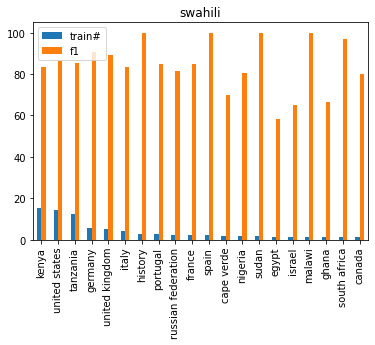

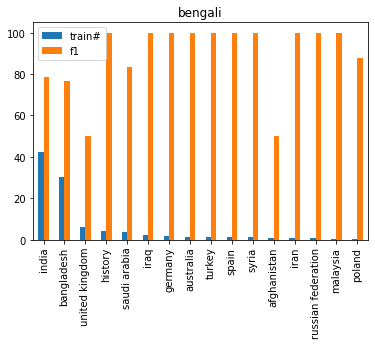

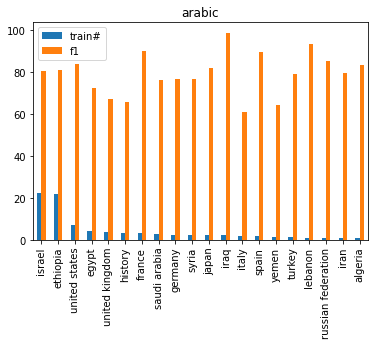

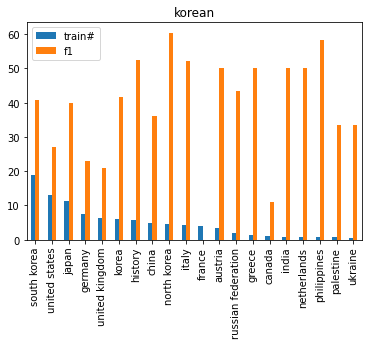

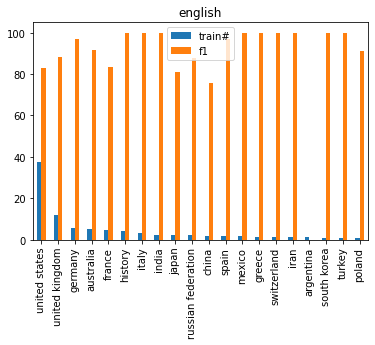

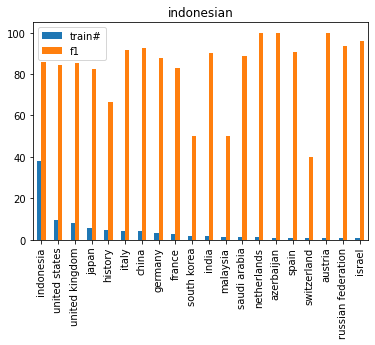

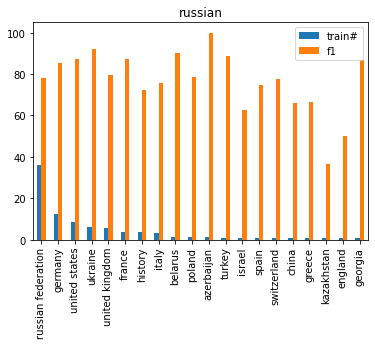

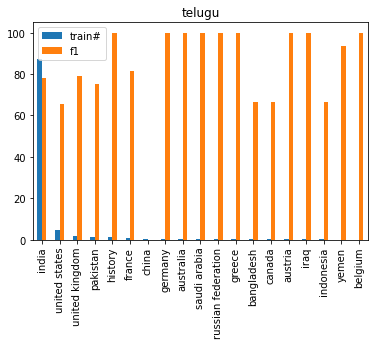

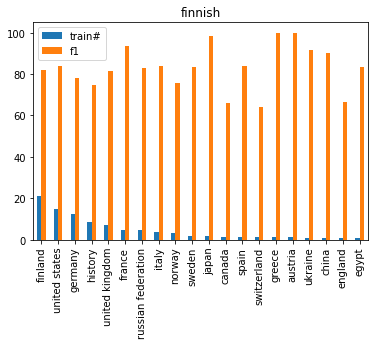

In [289]:

for key0 in count_train.keys():
    if len(count_train[key0])>1:
        dict1=count_train[key0]
        dict2=dev_result[key0]
        keys = list(dict1.keys() & dict2.keys())
        total=sum([dict1.get(x, 0) for x in keys])
        percnt=[(dict1.get(x, 0)/total)*100 for x in keys]
        f1=[dict2.get(x, 0) for i,x in enumerate(keys)]
#         f1_raw=[dict2.get(x, 0)*dict1[x] for i,x in enumerate(keys)]
#         f1_norm=[100*x/max(f1_raw) for i,x in enumerate(f1_raw)]
        
        import pandas as pd
        import matplotlib.pyplot as plt

        df = pd.DataFrame({'train#':percnt,
                          'f1':f1},
                          index=keys)
        df = df.sort_values('train#',ascending=False).iloc[:20,:]

        # # df = df.astype(int)
        # df.plot.bar(x=keys)
        ax = df.plot.bar( rot=90,title=key0)


#### train-f1 graph normalized
- just # of train examples for mentioning specific country for each language [divided by 100/total_count and sorted]
- vs normalized f1: the average f1 for those examples multiplied by 100*count and divided by the maximum count

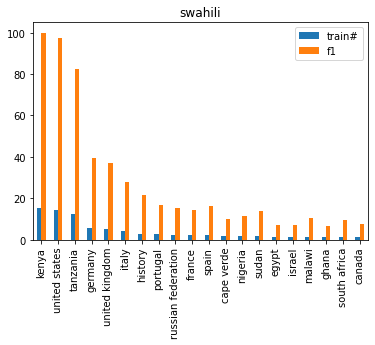

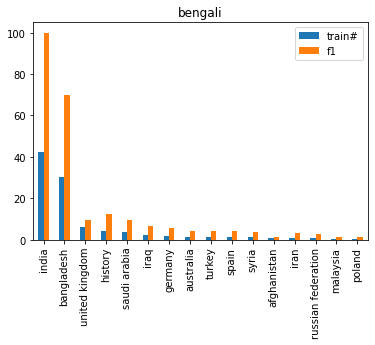

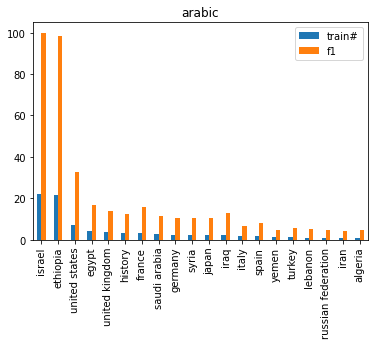

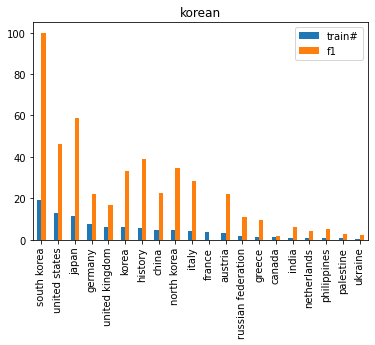

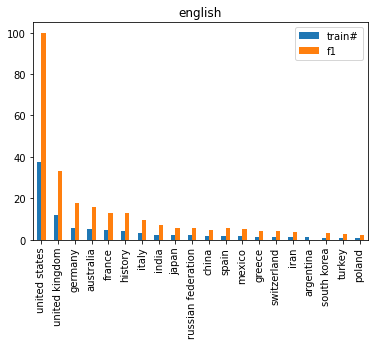

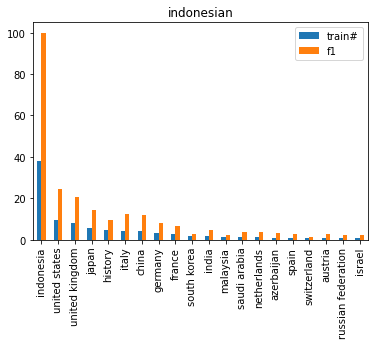

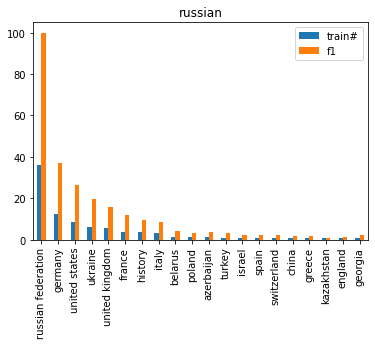

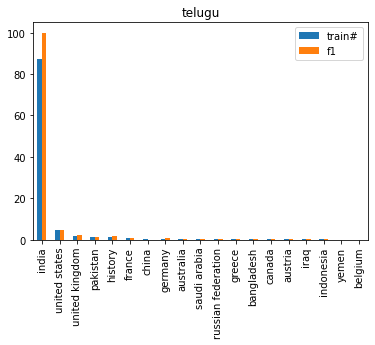

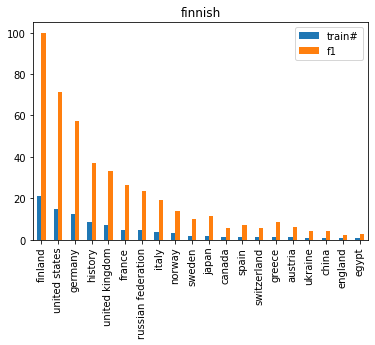

In [288]:
for key0 in count_train.keys():
    if len(count_train[key0])>1:
        dict1=count_train[key0]
        dict2=dev_result[key0]
        keys = list(dict1.keys() & dict2.keys())
        total=sum([dict1.get(x, 0) for x in keys])
        percnt=[(dict1.get(x, 0)/total)*100 for x in keys]
        f1_raw=[dict2.get(x, 0)*dict1[x] for i,x in enumerate(keys)]
        f1_norm=[100*x/max(f1_raw) for i,x in enumerate(f1_raw)]
        
        import pandas as pd
        import matplotlib.pyplot as plt

        df = pd.DataFrame({'train#':percnt,
                          'f1':f1_norm},
                          index=keys)
        df = df.sort_values('train#',ascending=False).iloc[:20,:]

        # # df = df.astype(int)
        # df.plot.bar(x=keys)
        ax = df.plot.bar( rot=90,title=key0)
